In [24]:
import pandas as pd

# Load the data file
climate_file = 'climate-daily.csv'
climate_data = pd.read_csv(climate_file)

# Convert 'LOCAL_DATE' to datetime format
climate_data['LOCAL_DATE'] = pd.to_datetime(climate_data['LOCAL_DATE'], errors='coerce')

# Ensure dataset is sorted by date
climate_data = climate_data.sort_values('LOCAL_DATE').reset_index(drop=True)

# Step 1: Add missing dates
# Create a complete date range from the minimum to the maximum date in the dataset
full_date_range = pd.date_range(start=climate_data['LOCAL_DATE'].min(), 
                                end=climate_data['LOCAL_DATE'].max())

# Reindex the dataset to include all dates
climate_data = climate_data.set_index('LOCAL_DATE').reindex(full_date_range).reset_index()

# Rename the reindexed date column back to 'LOCAL_DATE'
climate_data = climate_data.rename(columns={'index': 'LOCAL_DATE'})

# Step 2: Handle missing TOTAL_PRECIPITATION
# Interpolate values if gaps are less than 2 days
climate_data['TOTAL_PRECIPITATION'] = climate_data['TOTAL_PRECIPITATION'].interpolate(
    method='linear', limit=1, limit_direction='both')

# Set remaining missing TOTAL_PRECIPITATION values to 0
climate_data['TOTAL_PRECIPITATION'] = climate_data['TOTAL_PRECIPITATION'].fillna(0)

# Step 3: Interpolate missing MEAN_TEMPERATURE values
climate_data['MEAN_TEMPERATURE'] = climate_data['MEAN_TEMPERATURE'].interpolate(
    method='linear', limit_direction='both')

# Step 4: Keep only required columns
filtered_climate_data = climate_data[['LOCAL_DATE', 'MEAN_TEMPERATURE', 'TOTAL_PRECIPITATION']]

# Save or return the processed dataset
filtered_climate_data.to_csv('processed_climate_data.csv', index=False)

print(filtered_climate_data.head())

  LOCAL_DATE  MEAN_TEMPERATURE  TOTAL_PRECIPITATION
0 2002-06-04              11.6                  4.8
1 2002-06-05              17.4                  3.4
2 2002-06-06              15.3                  0.0
3 2002-06-07              16.2                  0.0
4 2002-06-08              18.3                  0.0


In [25]:
# Define thresholds
rain_intensity_threshold = 10  # mm (for individual day filtering)
# average_intensity_threshold = 20  # mm/day
total_precipitation_threshold =55  # mm

# Use the filtered DataFrame from the previous step
filtered_climate_data['is_high_precip'] = filtered_climate_data['TOTAL_PRECIPITATION'] > rain_intensity_threshold

# Step 1: Group consecutive high-precipitation days into events
filtered_climate_data['event_id'] = (filtered_climate_data['is_high_precip'] != filtered_climate_data['is_high_precip'].shift()).cumsum()

# Step 2: Identify only high-precipitation days and summarize rain events
rain_events = filtered_climate_data[filtered_climate_data['is_high_precip']].groupby('event_id')

# Step 3: Summarize rain events
event_summaries = rain_events.agg(
    start_date=('LOCAL_DATE', 'min'),
    end_date=('LOCAL_DATE', 'max'),
    duration=('LOCAL_DATE', lambda x: (x.max() - x.min()).days + 1),
    total_precipitation=('TOTAL_PRECIPITATION', 'sum')
)

# Step 4: Calculate average intensity for each rain event
event_summaries['average_intensity'] = (
    event_summaries['total_precipitation'] / event_summaries['duration']
)

# Step 5: Filter by total precipitation and average intensity thresholds
significant_events = event_summaries[
    (event_summaries['total_precipitation'] > total_precipitation_threshold)
    # (event_summaries['average_intensity'] > average_intensity_threshold)
]

# Extract all unique years from the dataset
all_years = filtered_climate_data['LOCAL_DATE'].dt.year.unique()

# Count the number of significant events by year
significant_events['year'] = significant_events['start_date'].dt.year
events_per_year = significant_events.groupby('year').size().reset_index(name='event_count')

# Add missing years with 0 events
events_per_year_full = pd.DataFrame({'year': all_years})
events_per_year_full = events_per_year_full.merge(events_per_year, on='year', how='left')
events_per_year_full['event_count'] = events_per_year_full['event_count'].fillna(0).astype(int)

# Display the updated DataFrame and the count of events per year
print("Significant Rain Events (Filtered by Average Intensity > 30 mm):")
print(significant_events)

print("\nNumber of Significant Events Per Year (Including Years with 0 Events):")
print(events_per_year_full)

# Save the updated significant events and counts to CSV
significant_events.to_csv('significant_rain_events_filtered.csv', index=False)
events_per_year_full.to_csv('significant_events_per_year_filtered.csv', index=False)


Significant Rain Events (Filtered by Average Intensity > 30 mm):
         start_date   end_date  duration  total_precipitation  \
event_id                                                        
158      2006-06-27 2006-06-29         3                 57.2   
198      2007-07-19 2007-07-19         1                 61.1   
300      2009-07-25 2009-07-26         2                 61.2   
348      2010-08-21 2010-08-22         2                 61.6   
482      2013-07-07 2013-07-08         2                135.3   
488      2013-08-26 2013-08-27         2                 60.0   
580      2015-10-28 2015-10-28         1                 58.3   
666      2018-04-14 2018-04-16         3                 89.3   
682      2018-08-06 2018-08-08         3                 91.0   
772      2020-01-11 2020-01-12         2                 68.1   
794      2020-08-02 2020-08-04         3                 74.9   
936      2024-04-03 2024-04-03         1                 56.6   
950      2024-07-15 2024-

C:\Users\mayac\AppData\Local\Temp\ipykernel_24804\3715390706.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_climate_data['is_high_precip'] = filtered_climate_data['TOTAL_PRECIPITATION'] > rain_intensity_threshold
C:\Users\mayac\AppData\Local\Temp\ipykernel_24804\3715390706.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_climate_data['event_id'] = (filtered_climate_data['is_high_precip'] != filtered_climate_data['is_high_precip'].shift()).cumsum()
C:\Users\mayac\AppData\Local\Temp

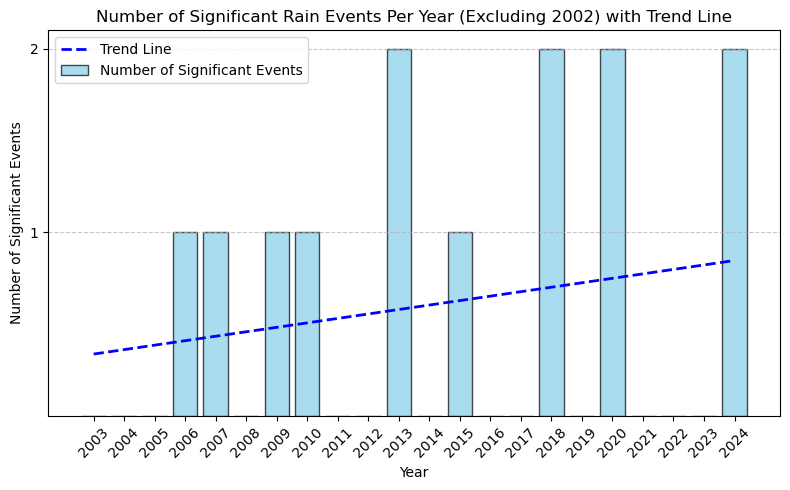

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate yearly total precipitation
yearly_total_precip = filtered_climate_data.groupby(filtered_climate_data['LOCAL_DATE'].dt.year)['TOTAL_PRECIPITATION'].sum().reset_index()
yearly_total_precip.columns = ['year', 'total_precipitation']

# Add relative percentage change
yearly_total_precip['precip_change'] = yearly_total_precip['total_precipitation'].pct_change() * 100

# Color coding for increase or decrease
yearly_total_precip['change_label'] = yearly_total_precip['precip_change'].apply(
    lambda x: 'Increase' if x > 0 else 'Decrease'
)

# Step 1: Exclude the year 2002
events_per_year_filtered = events_per_year_full[events_per_year_full['year'] != 2002]

# Step 2: Extract x and y for linear regression
x_events_filtered = events_per_year_filtered['year']
y_events_filtered = events_per_year_filtered['event_count']

# Step 3: Fit a linear trend line
coefficients_events_filtered = np.polyfit(x_events_filtered, y_events_filtered, 1)
trend_line_events_filtered = np.polyval(coefficients_events_filtered, x_events_filtered)

# Step 4: Plot the bar chart with the linear trend line for number of significant events
plt.figure(figsize=(8, 5))
bars = plt.bar(
    x_events_filtered,
    y_events_filtered,
    color='skyblue',
    edgecolor='black',
    alpha=0.7,
    label='Number of Significant Events'
)

# Add the trend line
plt.plot(
    x_events_filtered,
    trend_line_events_filtered,
    color='blue',
    linewidth=2,
    linestyle='--',
    label='Trend Line'
)

# Labeling and formatting
plt.xlabel('Year')
plt.ylabel('Number of Significant Events')
plt.title('Number of Significant Rain Events Per Year (Excluding 2002) with Trend Line')

# Set y-axis ticks to 1, 2
plt.yticks([1, 2])

plt.xticks(x_events_filtered, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Final adjustments and show plot
plt.tight_layout()
plt.show()


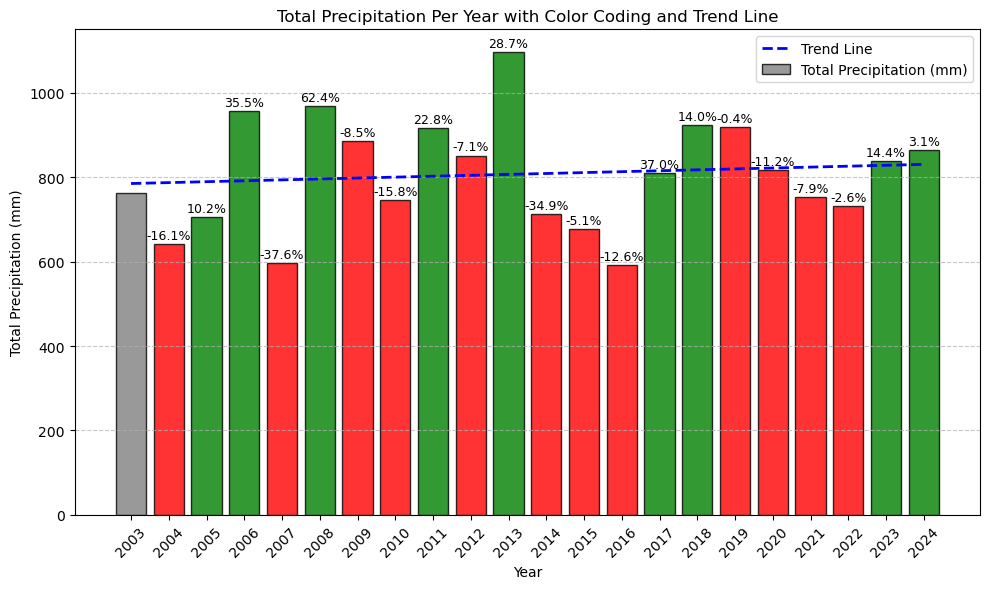

In [27]:
# --- Total Precipitation Per Year ---
# Calculate total precipitation per year
total_precip_per_year = (
    filtered_climate_data.groupby(filtered_climate_data['LOCAL_DATE'].dt.year)['TOTAL_PRECIPITATION']
    .sum()
    .reset_index()
)
total_precip_per_year.columns = ['year', 'total_precipitation']
total_precip_per_year = total_precip_per_year[total_precip_per_year['year'] != 2002]

# Calculate percentage change
total_precip_per_year['pct_change'] = total_precip_per_year['total_precipitation'].pct_change() * 100
total_precip_per_year['color'] = total_precip_per_year['pct_change'].apply(
    lambda x: 'green' if x > 0 else 'red' if x < 0 else 'gray'
)

# Fit a linear trend line
x = total_precip_per_year['year']
y = total_precip_per_year['total_precipitation']
coefficients = np.polyfit(x, y, 1)
trend_line = np.polyval(coefficients, x)

# Plot the bar chart with color-coding for total precipitation
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(
    total_precip_per_year['year'], 
    total_precip_per_year['total_precipitation'], 
    color=total_precip_per_year['color'], 
    edgecolor='black', 
    alpha=0.8, 
    label='Total Precipitation (mm)'
)

# Add the trend line
ax.plot(
    total_precip_per_year['year'], 
    trend_line, 
    color='blue', 
    linewidth=2, 
    linestyle='--', 
    label='Trend Line'
)

# Annotate bars with relative percentage change
for bar, pct in zip(bars, total_precip_per_year['pct_change']):
    if not pd.isna(pct):  # Avoid NaN for the first year
        ax.text(
            bar.get_x() + bar.get_width() / 2, 
            bar.get_height() + 5, 
            f"{pct:.1f}%", 
            ha='center', 
            va='bottom', 
            fontsize=9
        )

# Labeling and formatting
ax.set_title('Total Precipitation Per Year with Color Coding and Trend Line')
ax.set_xlabel('Year')
ax.set_ylabel('Total Precipitation (mm)')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Rotate x-axis labels for better readability
plt.xticks(total_precip_per_year['year'], rotation=45)

# Final adjustments and show plot
plt.tight_layout()
plt.show()

# Save results to CSV (if required)
events_per_year_filtered.to_csv('events_per_year.csv', index=False)
total_precip_per_year.to_csv('yearly_precipitation_with_trends.csv', index=False)

In [28]:

# Define thresholds for snowmelt
snow_melt_temp_threshold = 0  # Temperature in °C
min_snow_melt_duration = 5  # Minimum consecutive days

# Filter the dataset (from previous steps)
temperature_data = filtered_climate_data[['LOCAL_DATE', 'MEAN_TEMPERATURE']].copy()

# Step 1: Identify periods where temperature drops below 0°C
temperature_data['is_below_freezing'] = temperature_data['MEAN_TEMPERATURE'] < snow_melt_temp_threshold
temperature_data['freeze_event_id'] = (temperature_data['is_below_freezing'] != temperature_data['is_below_freezing'].shift()).cumsum()

# Step 2: Mark periods after freezing events
# Find the last date of each freezing event
last_freeze_dates = temperature_data[temperature_data['is_below_freezing']].groupby('freeze_event_id').agg(
    last_freeze_date=('LOCAL_DATE', 'max')
)

# Merge last freeze dates back into the main DataFrame
temperature_data = temperature_data.merge(last_freeze_dates, left_on='freeze_event_id', right_index=True, how='left')

# Replace NaT in last_freeze_date with a very early date to avoid invalid comparisons
temperature_data['last_freeze_date'] = temperature_data['last_freeze_date'].fillna(pd.Timestamp.min)

# Step 3: Identify snowmelt days (above threshold) after a freeze
temperature_data['is_snow_melt'] = (
    (temperature_data['MEAN_TEMPERATURE'] > snow_melt_temp_threshold) &
    (temperature_data['LOCAL_DATE'] > temperature_data['last_freeze_date'])
)


# Step 4: Group consecutive snowmelt days into events
temperature_data['melt_event_id'] = (temperature_data['is_snow_melt'] != temperature_data['is_snow_melt'].shift()).cumsum()

# Step 5: Summarize snow melt events
melt_events = temperature_data[temperature_data['is_snow_melt']].groupby('melt_event_id').agg(
    start_date=('LOCAL_DATE', 'min'),
    end_date=('LOCAL_DATE', 'max'),
    duration=('LOCAL_DATE', lambda x: (x.max() - x.min()).days + 1),
    mean_temperature=('MEAN_TEMPERATURE', 'mean')
)

# Step 6: Filter snow melt events by minimum duration
significant_melt_events = melt_events[melt_events['duration'] >= min_snow_melt_duration]

# Display the filtered snow melt events
print("Significant Snow Melt Events After Freezing Periods:")
print(significant_melt_events)

# (Optional) Save the results to a CSV file
significant_melt_events.to_csv('significant_snow_melt_events_after_freeze.csv', index=False)


Significant Snow Melt Events After Freezing Periods:
              start_date   end_date  duration  mean_temperature
melt_event_id                                                  
1             2002-06-04 2002-11-15       165         18.391515
3             2002-11-18 2002-11-26         9          3.566667
7             2002-12-10 2002-12-15         6          2.100000
9             2002-12-18 2002-12-22         5          3.040000
23            2003-03-15 2003-03-29        15          6.420000
...                  ...        ...       ...               ...
659           2023-12-23 2023-12-31         9          4.500000
663           2024-01-08 2024-01-13         6          2.533333
665           2024-01-23 2024-02-12        21          3.019048
671           2024-03-01 2024-03-19        19          6.084211
673           2024-03-25 2024-11-24       245         16.370408

[125 rows x 4 columns]


C:\Users\mayac\AppData\Local\Temp\ipykernel_24804\2724910334.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant_events['days_between_events'] = significant_events['start_date'].diff().dt.days


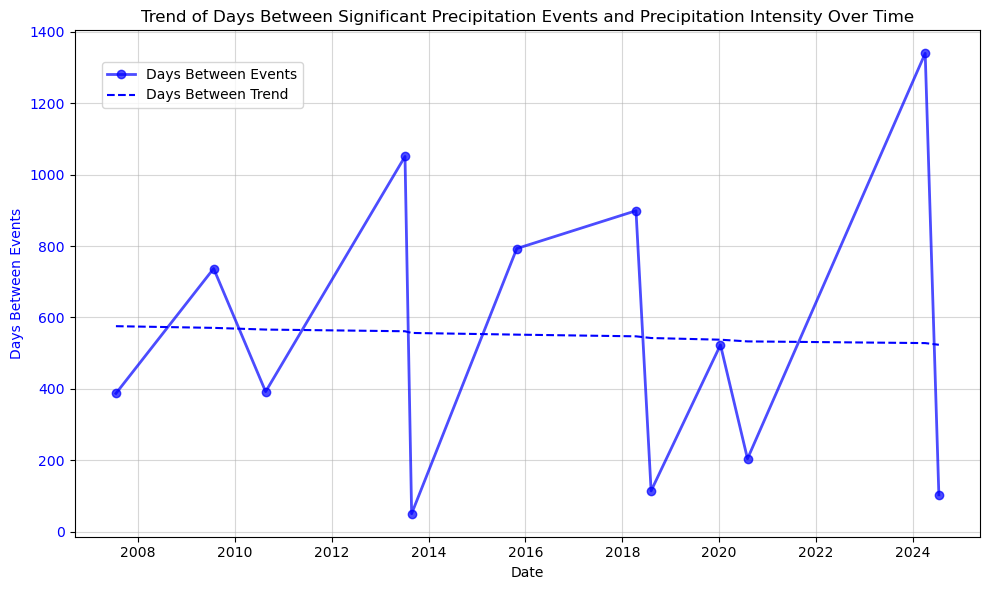

In [29]:
# Calculate the number of days between consecutive events
significant_events['days_between_events'] = significant_events['start_date'].diff().dt.days

# Remove the first row, as it will have NaN value for 'days_between_events'
significant_events = significant_events.dropna(subset=['days_between_events'])

# Extract x (time), y1 (days between events), and y2 (total precipitation)
x_time = significant_events['start_date']  # x-axis is the start date of the events
y_days_between = significant_events['days_between_events']  # y1-axis is the number of days between events
y_total_precip = significant_events['total_precipitation']  # y2-axis is the total precipitation of the events

# Fit linear trend lines
trend_days_between = np.poly1d(np.polyfit(range(len(y_days_between)), y_days_between, 1))
trend_total_precip = np.poly1d(np.polyfit(range(len(y_total_precip)), y_total_precip, 1))

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot days between events on the left y-axis
ax1.plot(x_time, y_days_between, label='Days Between Events', color='blue', linewidth=2, marker='o', alpha=0.7)
ax1.plot(x_time, trend_days_between(range(len(y_days_between))), color='blue', linestyle='--', label='Days Between Trend')
ax1.set_xlabel('Date')
ax1.set_ylabel('Days Between Events', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Add legends and grid
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
ax1.grid(alpha=0.5)

# Title and layout
plt.title('Trend of Days Between Significant Precipitation Events and Precipitation Intensity Over Time')
plt.tight_layout()
plt.show()
